#### Directories etc

In [5]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from collections import defaultdict
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
pd.options.mode.chained_assignment = None  # default='warn'
import ete3
import matplotlib.pyplot as plt
from statistics import mode
from scipy.stats import chi2
import subprocess

In [7]:
project_dir = 'F:/Project_Data/Project_11'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
dictionary_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Dictionaries'
tb_species = 'NC_000962.3' 
tb_genome_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
mycobrowser_dir = 'F:/Datasets/Data_From_Publications'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [9]:
for record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    full_sequence = str(record.seq)

In [11]:
with open(project_dir + '/Thoth_Full_Run/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
#with open(project_dir + '/Mutation_Counts/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    full_sample_zero_and_non_zero_mutation_counts = pickle.load(f)  

In [13]:
compass_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/COMPASS.csv', names = ['species', 'start', 'stop','count'])
compass_dict = {}
for i, r in compass_df.iterrows():
    for k in range(r['start'], r['stop']):     #  Should be start-1 but adjusted to be consistent with mutation position convention
        compass_dict[k] = 'Y'

In [15]:
mycobrowser_df = pd.read_excel(mycobrowser_dir+'/Mycobrowser_Release_4.xlsx')
temp_cds = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand','Product','Name','Functional_Category','Gene Ontology']]      #Just CDS
mycobrowser_cds_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_cds_boundaries.append((r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand, r['Name'], r['Functional_Category'], r['Gene Ontology']))
mycobrowser_cds_boundaries.sort(key = lambda x: x[2])

In [16]:
def bin_formula(position_3_counts, tot_bin_counts):
    return 1- binom.cdf(position_3_counts-1, tot_bin_counts,1/3)

In [108]:
def process_blast_output(infile_loc):
    trans = util.Translator()
    blast_results = pd.read_csv(infile_loc, header = None)
    blast_results.columns = ['query_accession_ver', 'subject_accession_ver', 'query_length', 'subject_length', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 'query_start_alignment', 'query_end_alignment', 'subject_start_alignment', 'subject_end_alignment', 'e_value', 'bit_score']
    for i, r in blast_results.iterrows():
        if '@' in r.query_accession_ver:
            blast_results.at[i, 'query_species'] = (r.query_accession_ver.split('@')[0])
        else:
            blast_results.at[i, 'query_species'] = '_'.join(r.query_accession_ver.split('_')[0:2])
        if '@' in r.subject_accession_ver:
            blast_results.at[i, 'subject_species'] = (r.subject_accession_ver.split('@')[0])
        else:
            blast_results.at[i, 'subject_species'] = '_'.join(r.subject_accession_ver.split('_')[0:2])
    #blast_results = blast_results.query('not (query_species == subject_species)')
    blast_results = blast_results.loc[blast_results.groupby(['query_accession_ver','subject_species'])['bit_score'].idxmax()]
    return blast_results

In [114]:
def keep_reciprocal_best_hits(query_df, reverse_query_df):
    temp_1_dict = {}
    temp_2_dict = {}
    for i, r in query_df.iterrows():
        temp_1_dict[r['query_accession_ver']] = r['subject_accession_ver']
    for i, r in reverse_query_df.iterrows():
        temp_2_dict[r['query_accession_ver']] = r['subject_accession_ver']
    for i, r in query_df.iterrows():
        if temp_1_dict[r['query_accession_ver']] in temp_2_dict and temp_2_dict[temp_1_dict[r['query_accession_ver']]] == r['query_accession_ver']:
            query_df.at[i, 'reciprocal_best_hit'] = 'Y'
        else:
            query_df.at[i, 'reciprocal_best_hit'] = 'N'
    output = query_df[query_df.reciprocal_best_hit == 'Y'] 
    output['species_count'] = output.groupby('query_accession_ver')['query_accession_ver'].transform('size')
    return output

In [19]:
def compass_coverage(start, stop):
    compass_overlap = 0
    for i in range(start, stop):
        if i in compass_dict:
            compass_overlap += 1
    return (compass_overlap/(stop - start))

In [21]:
def show_bin_counts(mutationcounts):
    bin_counts = [0,0,0]
    total_compass_overlap = 0
    for n in range(int(len(mutationcounts)/3)):
        temp_counts = [0,0,0]
        compass_overlap = 0
        for m in range(3): 
            if start+3*n+m in compass_dict:
                compass_overlap += 1
                total_compass_overlap += 1
            temp_counts[m % 3] = mutationcounts[3*n+m]
        if sum(temp_counts) < 10 and compass_overlap == 0:
            for m in range(3):
                bin_counts[m] += temp_counts[m]
    return (bin_counts, sum(bin_counts)/len(mutation_counts), total_compass_overlap / len(mutation_counts))

In [23]:
def score_region(mutationcounts, start):
    bin_counts = [0,0,0]
    for n in range(int(len(mutationcounts)/3)):
        temp_counts = [0,0,0]
        compass_overlap = 0
        for m in range(3): 
            if start+3*n+m in compass_dict:
                compass_overlap = 1
            temp_counts[m % 3] = mutationcounts[3*n+m]
        if sum(temp_counts) < 10 and compass_overlap == 0:
            for m in range(3):
                bin_counts[m] += temp_counts[m]
    return bin_formula(bin_counts[2], sum(bin_counts))

#### Mycobrowswer annotated CDS regions

C:\Users\nicho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

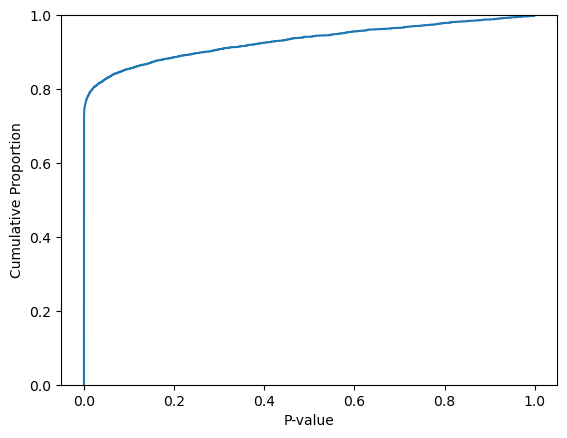

In [96]:
scores =[]
scores_lengths =[]
for (locus, product, start, stop, strand, name, functional_category, gene_ontology) in mycobrowser_cds_boundaries: 
    if compass_coverage(start, stop) > 0.5:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        mutation_counts_2 = mutation_counts
    else:
        mutation_counts_2 = list(reversed(mutation_counts))
    scores.append(score_region(mutation_counts_2, start))
    scores_lengths.append([locus, sum(mutation_counts_2),score_region(mutation_counts_2, start), mutation_counts_2])
a = sns.ecdfplot(scores)
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

In [94]:
a.figure.savefig('figure_5b.png',dpi=600, facecolor='w')

C:\Users\nicho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nicho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


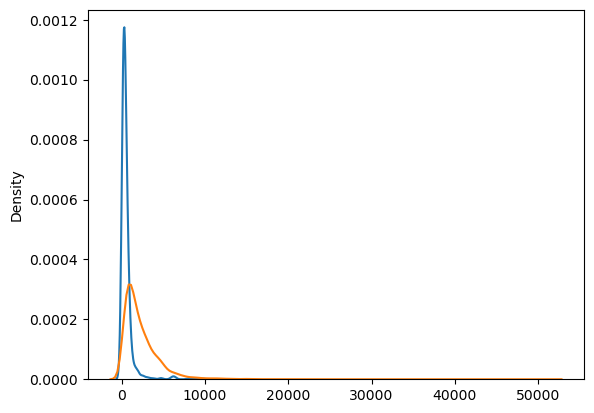

In [98]:
sns.kdeplot([x[1] for x in scores_lengths if x[2] > 0.01])
sns.kdeplot([x[1] for x in scores_lengths if x[2] < 0.01])
plt.show()

C:\Users\nicho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


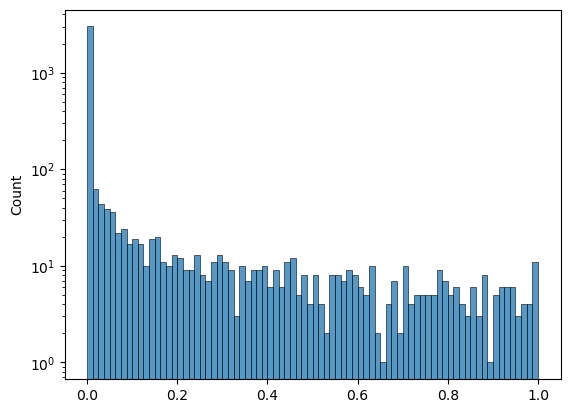

In [29]:
a = sns.histplot(scores, log_scale=(False, True), bins=80)

In [ ]:
a.figure.savefig('figure_5a.png',dpi=600, facecolor='w')

#### Percentage of true positives at 0.05 cut off

In [44]:
len([x for x in scores if x < 0.05])/len(scores)

0.8287292817679558

#### Intergenic MORFs

In [46]:
min_intergenic_length = 50
candidate_intergenic_morfs = []
max_stop = 0
ORFFinder = orffn.ORF_Finder(full_sequence)
for n,cds in enumerate(mycobrowser_cds_boundaries):
    stop = cds[3]
    max_stop = max(stop, max_stop)
    if n < len(mycobrowser_cds_boundaries) - 1:
        if mycobrowser_cds_boundaries[n+1][2] > max_stop + min_intergenic_length:
            a =ORFFinder.max_orf(max_stop-10, mycobrowser_cds_boundaries[n+1][2]+10, output_orfs = 'Nested', min_orf_length = min_intergenic_length)
            for x in a:
                candidate_intergenic_morfs.append(x)

C:\Users\nicho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

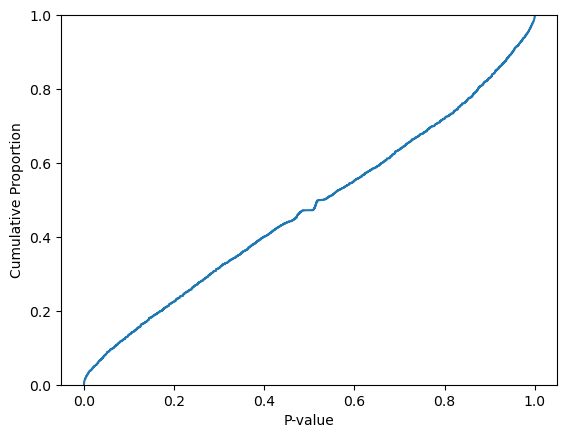

In [48]:
scores_4 =[]
for (start, stop, strand, length) in candidate_intergenic_morfs: 
    if compass_coverage(start, stop) > 0.5:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        mutation_counts_2 = mutation_counts
    else:
        mutation_counts_2 = list(reversed(mutation_counts))
    scores_4.append([(start, stop, strand, length),score_region(mutation_counts_2, start)])
a = sns.ecdfplot([x[1] for x in scores_4])
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')
#plt.xscale('log')

#### All MORFs

In [50]:
min_intergenic_length = 50
candidate_morfs = []
ORFFinder = orffn.ORF_Finder(full_sequence)
a =ORFFinder.max_orf(0, len(full_sequence)-1, output_orfs = 'Nested', min_orf_length = min_intergenic_length)
for x in a:
    candidate_morfs.append(x)

In [52]:
len(candidate_morfs)

63720

#### Eliminate negative strand instances where they would have same pattern of 3rd codon 

In [54]:
candidate_morfs.sort(key = lambda x: x[3], reverse = True)
maximal_reading_frame_orfs = [candidate_morfs[0]]
for n, morf in tqdm(enumerate(candidate_morfs)):
    if n==0:
        continue
    overlap = 0
    for m, morf2 in enumerate(candidate_morfs):
        if m == n and overlap == 0:
            maximal_reading_frame_orfs.append(morf)
            break
        else:
            if morf2[0] <= morf[0] and morf2[1] >= morf[1]:
                if morf2[2] == morf[2]:
                    if (morf2[1] - morf[1])%3 == 0:
                        overlap = 1
                        break
                else:
                    if (morf2[0] + 2- morf[0])%3 == 0:
                        overlap = 1
                        break        

63720it [06:09, 172.53it/s] 


##### Classify remaining ORFs into annotated, intergenic or overlapping

In [56]:
new_annotation_features_dict = {}
for (locus, product, start, stop, strand, name, functional_category, gene_ontology) in mycobrowser_cds_boundaries:
    if strand == 1:
        new_annotation_features_dict[stop] = (locus, product, start, stop, strand)
    else:
        new_annotation_features_dict[start] = (locus, product, start, stop, strand)

100%|██████████| 42441/42441 [00:18<00:00, 2282.53it/s]
C:\Users\nicho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

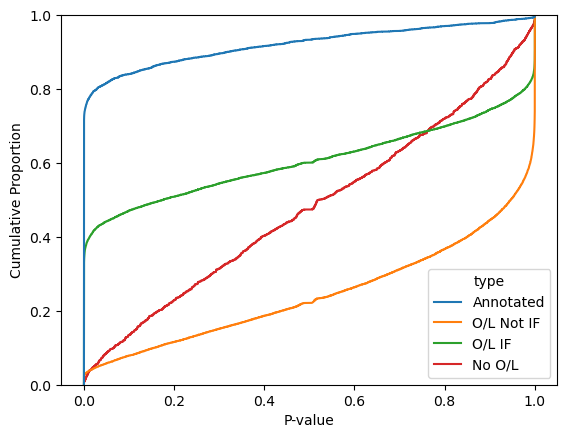

In [58]:
temp = []
for (start, stop, strand, length) in tqdm(maximal_reading_frame_orfs):
    if compass_coverage(start, stop)>0.5:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        score = score_region(mutation_counts, start)
    else:
        score = score_region(list(reversed(mutation_counts)), start)
  
#    if (strand == 1 and stop in new_annotation_features_dict) or (strand == -1 and start in new_annotation_features_dict):
    if (strand == 1 and stop in new_annotation_features_dict and new_annotation_features_dict[stop][4] == 1) or (strand == -1 and start in new_annotation_features_dict and new_annotation_features_dict[start][4] == -1):
        temp.append(['Annotated', score, (start, stop, strand, length)])
    else:
        overlap = 0
        for cds in mycobrowser_cds_boundaries:
            if (cds[2] <= start and cds[3] >= start) or (cds[2] <= stop and cds[3] >= stop):
                overlap = 1
                break
        if overlap == 1:
            if (cds[4] == strand and (cds[2] - start)%3 == 0) or (not(cds[4] == strand) and (cds[2] - start)%3 == 2):
                temp.append(['O/L IF', score, (start, stop, strand, length)])
            else:
                temp.append(['O/L Not IF', score, (start, stop, strand, length)])
        else:
            temp.append(['No O/L', score, (start, stop, strand, length)])
morf_df = pd.DataFrame(temp, columns = ['type','score','location'])
a = sns.ecdfplot(data = morf_df, x = 'score', hue = 'type')
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

In [ ]:
a.figure.savefig('figure_6.png',dpi=600, facecolor='w')

In [60]:
len(morf_df)

39726

In [62]:
len(morf_df[morf_df['type'] =='No O/L'])

2451

#### Identify alternative upstream starts to CDS which have significant mutation bias

100%|██████████| 42441/42441 [00:08<00:00, 4791.44it/s] 
C:\Users\nicho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

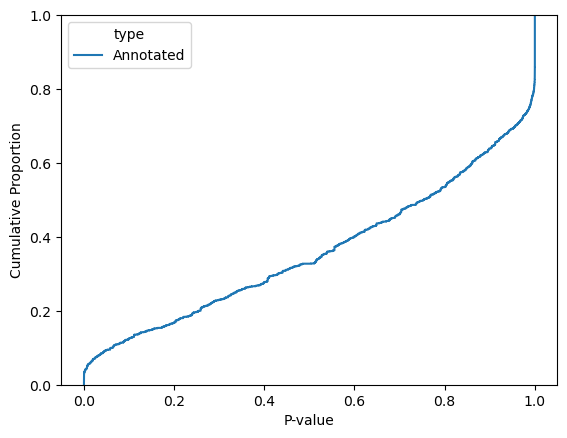

In [64]:
temp = []
for (start, stop, strand, length) in tqdm(maximal_reading_frame_orfs):
    if compass_coverage(start, stop)>0.5:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        score = score_region(mutation_counts, start)
    else:
        score = score_region(list(reversed(mutation_counts)), start)
  
    if (strand == 1 and stop in new_annotation_features_dict and new_annotation_features_dict[stop][4] == 1) or (strand == -1 and start in new_annotation_features_dict and new_annotation_features_dict[start][4] == -1):
        if (strand == 1 and stop in new_annotation_features_dict):
            dict_entry = new_annotation_features_dict[stop][2:4]
            locus = new_annotation_features_dict[stop][0]
        else:
            dict_entry = new_annotation_features_dict[start][2:4]
            locus = new_annotation_features_dict[start][0]
        if strand == 1 and start < dict_entry[0]:
            mutation_counts = full_sample_zero_and_non_zero_mutation_counts[dict_entry[0]:stop]
            score = score_region(mutation_counts, dict_entry[0])
            mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:dict_entry[0]]
            score_2 = score_region(mutation_counts, start)
            temp.append(['Annotated', score, score_2, (start, stop, strand, length), dict_entry, locus ])
        if strand == -1 and stop > dict_entry[1]:
            mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:dict_entry[1]]
            score = score_region(list(reversed(mutation_counts)), dict_entry[1])
            mutation_counts = full_sample_zero_and_non_zero_mutation_counts[dict_entry[1]:stop]
            score_2 = score_region(list(reversed(mutation_counts)), dict_entry[1])
            temp.append(['Annotated', score, score_2, (start, stop, strand, length), dict_entry, locus ])
upstream_df = pd.DataFrame(temp, columns = ['type','annotation_score','upstream_score','morf_location','annotation_location','Locus'])
a = sns.ecdfplot(data = upstream_df, x = 'upstream_score', hue = 'type')
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

In [68]:
dejesus_df = pd.read_csv(project_dir + '/DeJesus.csv')

In [70]:
temp = upstream_df[upstream_df['upstream_score'] < 0.001]
temp.sort_values(by=['Locus'], inplace=True)
temp_2 = temp.merge(dejesus_df, how='left', left_on='Locus', right_on='ORF');

In [72]:
for i, r in temp_2.iterrows():
    if r['Score'] < -0.7:
        if r['morf_location'][2] == 1:
            temp_2.at[i,'DeJesus_Proposal'] = (r['annotation_location'][0] + int(r['Offset'])*3, r['annotation_location'][1])
        elif r['morf_location'][2] == -1:
            temp_2.at[i,'DeJesus_Proposal'] = (r['annotation_location'][0], r['annotation_location'][1] + int(r['Offset'])*3)
    else:
        temp_2.at[i,'DeJesus_Proposal'] = ""


In [76]:
cols = ['Locus', 'upstream_score', 'annotation_location', 'morf_location', 'DeJesus_Proposal']
temp_2 = temp_2[cols]
temp_2
#temp_2.to_csv(project_dir+'/Reannotation_upstream_scores.csv')

,Locus,upstream_score,annotation_location,morf_location,DeJesus_Proposal
0,Rv0010c,8.152109e-04,"(13132, 13558)","(13132, 13591, -1, 456)",
1,Rv0230c,1.847569e-07,"(274982, 275963)","(274982, 276230, -1, 1245)",
2,Rv0231,4.637381e-04,"(276057, 277764)","(275874, 277764, 1, 1887)",
3,Rv0361,3.811302e-04,"(438821, 439649)","(438536, 439649, 1, 1110)",
4,Rv0496,1.385425e-11,"(586393, 587380)","(586345, 587380, 1, 1032)","(586345, 587380)"
5,Rv0653c,1.383018e-04,"(749233, 749929)","(749233, 750106, -1, 870)",
6,Rv0759c,2.401234e-07,"(853824, 854157)","(853824, 854226, -1, 399)","(853824, 854088)"
7,Rv0774c,1.819422e-11,"(867439, 868351)","(867439, 868558, -1, 1116)",
8,Rv0786c,1.572891e-09,"(881074, 881464)","(881074, 882091, -1, 1014)",
9,Rv0863,0.000000e+00,"(962598, 962880)","(962205, 962880, 1, 672)","(962679, 962880)"
